### Modelos a usar 

In [32]:
MODELS = [ # M3+
    '10_all_maj',
    'ft_maj', 
    '10_all_epubs',
    'gpt2-spanish',
    'gpt2-ft',
    'gpt2-blogs',
    'llama-7b-hf',
    'Llama-2-7b-hf'    
]

NAMES = dict(
    M0="Base",
    M1="Cloze",
    M2="Ngram",
    M3="AWD-wiki",
    M4="AWD-FT",
    M5="AWD-epubs",
    M6="GPT2",
    M7="GPT2-cuentos",
    M8="GPT2-blogs",
    M9="llama",
    M10="llama2"
)

**Models Descriptions**
- MO: Base model
- M1: Cloze Task predction
- M2: Ngrams model
- M3: AWD-LSTM model trained using articles form ES Wikipedia 
- M4: M3 model finetuned using Buenos Aires Corpus 
- M5: AWD-LSTM model trained using corpus of books in Spanish
- M6: GPT2-Spanish model from DeepEsp (pred estimada por Bruno)
- M7: GPT2-Spanish model from DeepEsp finetuneado con corpus de 2000 cuentos 
- M8: GPT2-Spanish model from DeepEsp finetuneado con corpus de blogs nacionales


### Librerias Necesarias

In [33]:
%pip install tqdm
%pip install rpy2==3.3.6
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Imports

In [34]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### R to python setup 

In [35]:
import rpy2

In [36]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri, conversion

In [37]:
pandas2ri.activate()
to_df = conversion.rpy2py
to_rdf = conversion.py2rpy

### R imports 

In [38]:
base = importr('base')
lme4 = importr("lme4")
utils = importr('utils')
stats = importr('stats')
remef_lib = r['source']('../eye_movements/remef.v0.6.10.R')

/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/vectors.py:969: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/brunobian/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2177: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  result, tz_parsed = tslib.array_to_datetime(
Lang Models:  88%|████████████████████████████    | 7/8 [10:00<01:25, 85.85s/it]


### Utils

In [39]:
coef_summary = r("function(xs) { return(data.frame(coef(summary(xs)))) }")
remef = r['remef']
def lmer(formula, data):
    return lme4.lmer(stats.as_formula(formula), data = data, REML = False)

## Analysis

In [40]:
base_data = to_rdf(pd.read_csv("../eye_movements/Data2020.csv", encoding='cp1252'))

/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [41]:
def get_data_for_model(prefix, base_data=base_data):
    dn = utils.read_csv(f'../resultados/{prefix}/all.csv')
    data = base.merge(base_data, dn)
    return data

In [42]:
def run_lmm(data, *extra):
    regr = " ".join(f"{x} +" for x in extra)
    return lmer(f'logFPRT ~ Nlaunchsite + invlength * freq + rpl + rpt + rps + {regr} (1 | sujid) + (1 | textid) + (1 | wordid)',  data)

In [43]:
lang_models_data = [get_data_for_model(model) for model in tqdm(MODELS, desc="Lang Models")]
all_models = [base_data, base_data, base_data] + lang_models_data

Lang Models:   0%|                                        | 0/8 [00:00<?, ?it/s]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Lang Models:  12%|████                            | 1/8 [00:01<00:10,  1.51s/it]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Lang Models:  25%|████████                        | 2/8 [00:02<00:08,  1.43s/it]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Lang Models:  38%|████████████                    | 3/8 [00:04<00:07,  1.43s/it]/home/brunobian/.

In [45]:
base_lmms = [run_lmm(base_data, *cols) for cols in tqdm([(), ("CLOZE_pred",), ("X4.gramcache.0.0001500000_0.15",)], desc="Base Models")]
lang_models_lmms = [run_lmm(model_data, 'awd') for model_data in tqdm(lang_models_data, desc="Lang Models")]
M = base_lmms + lang_models_lmms

Lang Models:   0%|                                        | 0/8 [00:00<?, ?it/s]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Lang Models: 100%|████████████████████████████████| 8/8 [00:51<00:00,  6.39s/it]


In [46]:
def t_value_and_remef(model_data, lm_model, name):
    fixed_efects = coef_summary(lm_model).index.values
    remef_df = r.cbind(model_data, remefData=remef(lm_model, fix = fixed_efects))
    mr = lmer("remefData ~ CLOZE_pred + (1|sujid) + (1|textid) + (1|wordid)", remef_df)
    res = coef_summary(lm_model)['t.value']
    res['CLOZE_pred_remef'] = coef_summary(mr)['t.value']['CLOZE_pred']
    return res.rename(name)

In [47]:
ccs = [
    t_value_and_remef(data, model, f"M{i}")
    for i, (data, model) in enumerate(zip(all_models, tqdm(M, desc="Running remef")))
]

Running remef:   0%|                                     | 0/11 [00:00<?, ?it/s]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Running remef:   9%|██▋                          | 1/11 [00:05<00:59,  5.96s/it]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Running remef:  18%|█████▎                       | 2/11 [00:11<00:51,  5.73s/it]/home/brunobian/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
Running remef:  27%|███████▉                     | 3/11 [00:17<00:45,  5.69s/it]/home/brunobian/.

In [48]:
df = pd.DataFrame(ccs).T

ix = list(df.index).index('CLOZE_pred_remef')
df = df.reindex([*df.index[:ix], *df.index[ix+1:], df.index[ix]])

renames = {
    "CLOZE_pred": "Cloze-Pred",
    "CLOZE_pred_remef": "Cloze-Remef",
    "X4.gramcache.0.0001500000_0.15": "Ngram",
    "awd": "Comp-Pred",
    "invlength:freq": "1/length:freq"
}
df.index = [renames.get(c, c) for c in df.index]

df.columns = [f"{c} | {NAMES[c]}" for c in df.columns]

df

,M0 | Base,M1 | Cloze,M2 | Ngram,M3 | AWD-wiki,M4 | AWD-FT,M5 | AWD-epubs,M6 | GPT2,M7 | GPT2-cuentos,M8 | GPT2-blogs,M9 | llama,M10 | llama2
(Intercept),283.008754,293.830955,271.864638,271.899899,276.084533,274.487819,281.257789,279.474999,281.971764,199.379405,280.820997
Nlaunchsite,44.437604,44.632825,43.923503,44.303614,44.204070,44.310050,44.034145,44.012181,44.000969,44.423622,44.305644
invlength,-18.150863,-18.556056,-19.098172,-19.413953,-19.282063,-18.591062,-20.044058,-19.896352,-19.897408,-18.249720,-19.930143
freq,-10.829610,-10.595400,-1.933659,-1.733827,-2.556459,-5.770295,-4.976962,-5.121528,-5.012300,-9.709554,-6.418875
rpl,4.142728,3.961059,4.333285,4.401136,4.191068,4.117377,4.449850,4.563032,4.610455,4.215537,4.250746
rpt,-3.928122,-3.280418,-3.874705,-4.251348,-4.676383,-4.676160,-4.560064,-4.148786,-4.254063,-4.470213,-4.764681
rps,-5.356682,-4.850063,-5.763752,-5.030321,-4.999477,-4.971784,-3.826630,-3.810529,-3.922001,-5.068645,-3.747695
1/length:freq,16.980784,17.167567,15.679300,14.707056,14.382165,16.911586,15.590313,15.581142,15.612366,17.202680,16.434818
Cloze-Pred,NaN,-16.234968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ngram,NaN,NaN,-21.019650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plots 

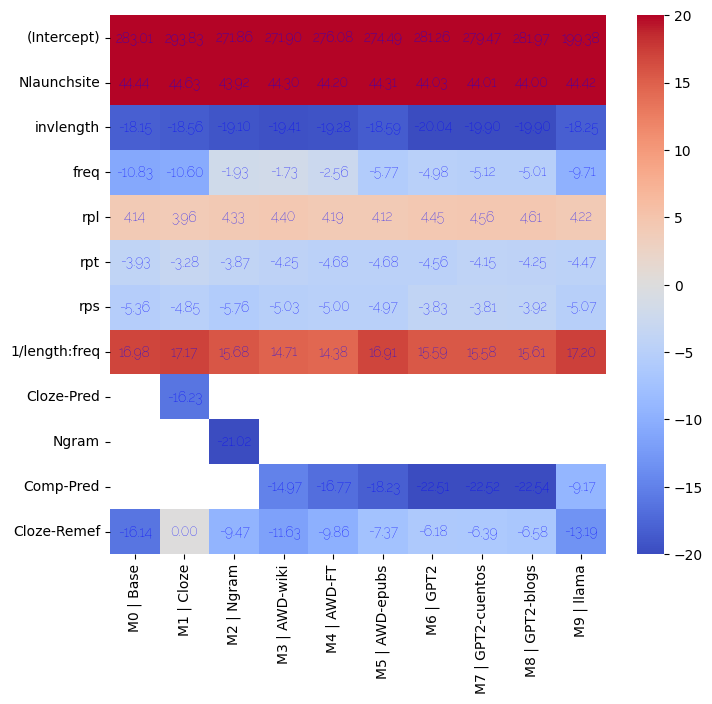

In [31]:
plt.figure(figsize=(8, 7))
font = {'family': 'Raleway','weight': 'bold','color':'b'}
sns.heatmap(df, annot=True,center=0, cmap='coolwarm', vmin=-20, vmax=20, fmt="0.2f", annot_kws=font)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('TablaCompleta.svg')


In [84]:
aics = pd.Series({f"M{i}": stats.AIC(m)[0] for i, m in enumerate(M)}, name='AIC')
aics

M0   -35945.444661
M1   -36199.168707
M2   -36370.136812
M3   -36265.278738
M4   -36427.378310
M5   -36427.360908
M6   -36427.047111
Name: AIC, dtype: float64

Lang Models:  20%|█████▌                      | 1/5 [34:43<2:18:55, 2083.85s/it]


<AxesSubplot: >

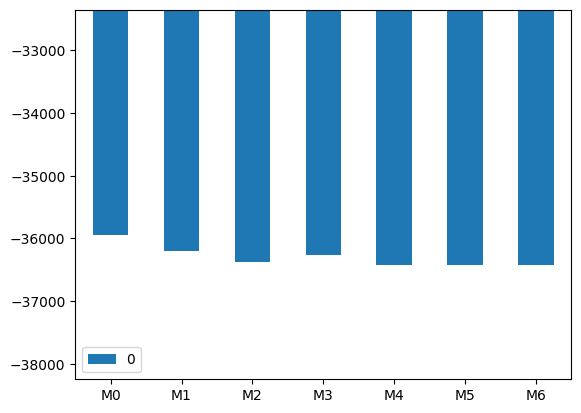

In [85]:
ax = aics.rename().to_frame().plot.bar(rot=0)
ax.set_ylim(top=aics.max() * 0.9)
ax

### LaTeX

In [87]:
def make_table(df):
    header = " & ".join(fr"\textbf{{{c}}}" for c in ["Feature", *df.columns]) + r"\\"
    data = "\\\\\n".join(
        r.Index + " & " + " & ".join(f"{getattr(r, f'_{i+1}'):0.2f}".replace('nan', '') for i in range(len(df.columns)))
        for r in df.itertuples()
    )
    
    return "\n".join([
        r"\begin{table}[h!]",
        r"\resizebox{\textwidth}{!}",
        "{",
        fr"\begin{{tabular}}{{l{ 'r' * len(df.columns)}}}",
        header,
        r"\hline",
        data,
        r"\end{tabular}",
        "}",
        r"\caption{}",
        r"\end{table}"
    ])

In [88]:
print(make_table(df))

\begin{table}[h!]
\resizebox{\textwidth}{!}
{
\begin{tabular}{lrrrrrrr}
\textbf{Feature} & \textbf{M0 | Base} & \textbf{M1 | Cloze} & \textbf{M2 | Ngram} & \textbf{M3 | AWD-epubs} & \textbf{M4 | GPT2} & \textbf{M5 | GPT2-cuentos} & \textbf{M6 | GPT2-blogs}\\
\hline
(Intercept) & 283.01 & 293.83 & 271.86 & 274.49 & 281.26 & 279.47 & 281.97\\
Nlaunchsite & 44.44 & 44.63 & 43.92 & 44.31 & 44.03 & 44.01 & 44.00\\
invlength & -18.15 & -18.56 & -19.10 & -18.59 & -20.04 & -19.90 & -19.90\\
freq & -10.83 & -10.60 & -1.93 & -5.77 & -4.98 & -5.12 & -5.01\\
rpl & 4.14 & 3.96 & 4.33 & 4.12 & 4.45 & 4.56 & 4.61\\
rpt & -3.93 & -3.28 & -3.87 & -4.68 & -4.56 & -4.15 & -4.25\\
rps & -5.36 & -4.85 & -5.76 & -4.97 & -3.83 & -3.81 & -3.92\\
1/length:freq & 16.98 & 17.17 & 15.68 & 16.91 & 15.59 & 15.58 & 15.61\\
Cloze-Pred &  & -16.23 &  &  &  &  & \\
Ngram &  &  & -21.02 &  &  &  & \\
Comp-Pred &  &  &  & -18.23 & -22.51 & -22.52 & -22.54\\
Cloze-Remef & -16.14 & 0.00 & -9.47 & -7.37 & -6.18 & -6.39 & -6

In [52]:
correlations = pd.Series({
    f"M{i+3}": data[["awd", "CLOZE_pred"]].corr(method='pearson').iloc[0, 1] 
    for i, data in enumerate(lang_models_data)
}, name="Correlation").to_frame()
correlations

,Correlation
M3,0.326578
M4,0.385925
M5,0.518868
M6,0.495891
M7,0.491762
M8,0.488638


In [ ]:
data = lang_models_data[0]
data[data.awd > -200].plot.density(x='awd', y="CLOZE_pred")

data[data.awd > -20][["awd", "CLOZE_pred"]].corr()

In [ ]:
sns.kdeplot(
    data=data[data.awd > -20],
    x="awd",
    y="CLOZE_pred",
    # thresh=.1,
)
